In [42]:
import pickle as pkl
from opt.mc_sim import *
import time
from common.variables import *
from opt.eval_policy import *

file_id = "msource_value_dic_12-31-2022-15-35-01.pkl"
filename = "output/" + file_id

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]
sourcingEnv = output_obj["mdp_env"]

# sourcingEnv2 = SourcingEnv(
#     lambda_arrival = model_params['mdp_env_params']['lambda'], # or 10
#     procurement_cost_vec = np.array(model_params['mdp_env_params']['procurement_cost_vec']),

#     supplier_lead_times_vec = np.array(model_params['mdp_env_params']['supplier_lead_times_vec']),
#     on_times = np.array(model_params['mdp_env_params']['on_times']), 
#     off_times = np.array(model_params['mdp_env_params']['off_times']),
#     fixed_costs = np.array(model_params['mdp_env_params']['fixed_costs'])) # np.array([np.Inf, np.Inf])) 

sourcingEnv2 = sourcingEnv

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

model_params['mdp_env_params']

costs_array_labeled = []

In [43]:
single_supplier_mean_costs = []
sing_supp_mean_cost = np.Inf
for s in range(sourcingEnv2.n_suppliers):

    kwargs = {"periods" : EVAL_PERIODS,
        "nested_mc_iters" : 100,
        "h_cost": model_params['policy_params']['h_cost'],
        "b_penalty" : model_params['policy_params']['b_penalty'],
        "supplier_index": s
    }

    single_supplier_costs = mc_with_policy(sourcingEnv2, start_state = s_custom, 
        use_tqdm = True,
        policy_callback = single_source_orderupto_policy,
        **kwargs)
    
    sing_supp_mean_cost_i = np.mean(single_supplier_costs)
    single_supplier_mean_costs.append(sing_supp_mean_cost_i)
    if sing_supp_mean_cost_i < sing_supp_mean_cost:
        single_supplier_costs_select = single_supplier_costs
        sing_supp_mean_cost = sing_supp_mean_cost_i

print(single_supplier_mean_costs)
print(np.min(single_supplier_mean_costs))

costs_array_labeled.extend([["SSN", c] for c in single_supplier_costs_select])

100%|██████████| 100/100 [00:00<00:00, 107.79it/s]

[4.178711823510963, 1.327990422223906]
1.327990422223906


In [44]:
myopic_costs = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = EVAL_PERIODS,
    nested_mc_iters = 5,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    max_order = 2, # BIG_S,
    policy_callback=myopic2_policy,
    use_tqdm = True)

print(np.mean(myopic_costs))
print(np.median(np.array(myopic_costs)))
print(np.std(np.array(myopic_costs)))

costs_array_labeled.extend([["M2", c] for c in myopic_costs])

100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

5.8504463758262455
5.526485209891843
0.6102552707703593


In [45]:
mc_avg_costs_ss = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = EVAL_PERIODS,
    nested_mc_iters = 100,
    policy_callback = ss_policy_fastest_supp_backlog,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    use_tqdm = True)

print(np.mean(np.array(mc_avg_costs_ss)))
print(np.median(np.array(mc_avg_costs_ss)))
print(np.std(np.array(mc_avg_costs_ss)))

costs_array_labeled.extend([["SS*", c] for c in mc_avg_costs_ss])

100%|██████████| 100/100 [00:00<00:00, 161.74it/s]

1.9181746521480934
1.8879809939200265
0.1556665348912516


In [46]:
mc_avg_costs_di = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = EVAL_PERIODS,
    nested_mc_iters = 30,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    max_order = BIG_S,
    policy_callback=dual_index_policy,
    use_tqdm = True
)

print(np.mean(np.array(mc_avg_costs_di)))
print(np.median(np.array(mc_avg_costs_di)))
print(np.std(np.array(mc_avg_costs_di)))

costs_array_labeled.extend([["DI", c] for c in mc_avg_costs_di])

100%|██████████| 30/30 [00:13<00:00,  2.16it/s]

1.1656025348212382
1.1794965293643989
0.17222069613343371


In [47]:
kwargs_lp = {
    "value_dic": output_obj["state_value_dic"], 
    "periods": EVAL_PERIODS, 
    "periods_val_it": 1,
    "nested_mc_iters": 30,
    "discount_fac": DISCOUNT_FAC,
    "h_cost": output_obj['model_params']['policy_params']['h_cost'],
    "b_penalty": output_obj['model_params']['policy_params']['b_penalty'],
    "n_visit_lim": N_VISIT_LIM,
    "default_ss_policy": ss_policy_fastest_supp_backlog,
    "safe_factor": SAFE_FACTOR,
    "sub_eval_periods": SUB_EVAL_PERIODS,
    "sub_nested_mc_iter": SUB_NESTED_MC_ITER,
    "max_stock": BIG_S,
    "approx_eval": True,
    "pol_dic": output_obj["pol_dic"],
    "env_filename": file_id
}

lp_mdp_costs = mc_with_policy(sourcingEnv, 
    policy_callback=lp_mdp_policy,
    use_tqdm = True,
    **kwargs_lp)

costs_array_labeled.extend([["LP", c] for c in lp_mdp_costs])

100%|██████████| 30/30 [00:24<00:00,  1.20it/s]


In [48]:
import os.path

# check if lp file exists
# os.path.isfile(fname) 

kwargs = {
    "value_dic": value_dic, 
    "periods": EVAL_PERIODS, 
    "periods_val_it": 1,
    "nested_mc_iters": 100,
    "max_stock": BIG_S,
    "discount_fac": DISCOUNT_FAC,
    "h_cost": model_params['policy_params']['h_cost'],
    "b_penalty": model_params['policy_params']['b_penalty'],
    "n_visit_lim": N_VISIT_LIM,
    "default_ss_policy": ss_policy_fastest_supp_backlog,
    "safe_factor": SAFE_FACTOR,
    "sub_eval_periods": SUB_EVAL_PERIODS,
    "sub_nested_mc_iter": SUB_NESTED_MC_ITER,
    "approx_eval": True,
    "pol_dic": output_obj['pol_dic']
}

mc_avg_costs = mc_with_policy(sourcingEnv2, 
    start_state = s_custom, 
    use_tqdm = True,
    policy_callback = eval_policy_from_policy_dic,
    **kwargs)

print(np.mean(mc_avg_costs))
print(np.median(mc_avg_costs))
print(np.std(mc_avg_costs))

costs_array_labeled.extend([["MCDP", c] for c in mc_avg_costs])

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]

1.0303110733300052
0.9982527851993928
0.20854679190124728


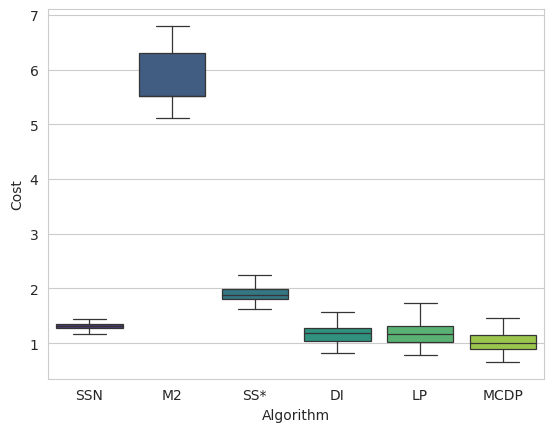

In [49]:
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(costs_array_labeled, columns =['Algorithm', 'Cost']) 

sns.set_style("whitegrid")
sns.color_palette("hls", 8)

sns.boxplot( x=df["Algorithm"], y=df["Cost"], width=0.8, showfliers=False, linewidth = 0.9, palette = 'viridis')
plt.show()

# https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f

In [50]:
df.groupby('Algorithm').agg('mean')

,Cost
Algorithm,
DI,1.165603
LP,1.207708
M2,5.850446
MCDP,1.030311
SS*,1.918175
SSN,1.327990
